# Set up

## Python path

In [1]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [169]:
from csaps import csaps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix, build_design_matrices
import seaborn as sns
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LinearRegression

import const
from heart_model import HeartDiseaseModel
import utils

## Constants

## Set defaults

In [3]:
utils.set_default_plot_style()

## Functions

# Generate sample data

In [4]:
try:
    sample_data = pd.read_csv(const.SPLINE_SAMPLE_DATA_PATH)
    x = sample_data["x"].values
    y = sample_data["y"].values
except FileNotFoundError:
    # helpful little package for sample data
    %pip install regressio --upgrade
    from regressio.datagen import generate_random_walk

    x, y = generate_random_walk(200, plot=False)
    x /= x.max()
    sample_data = pd.DataFrame({"x": x, "y": y})
    sample_data.to_csv(const.SPLINE_SAMPLE_DATA_PATH, index=False)

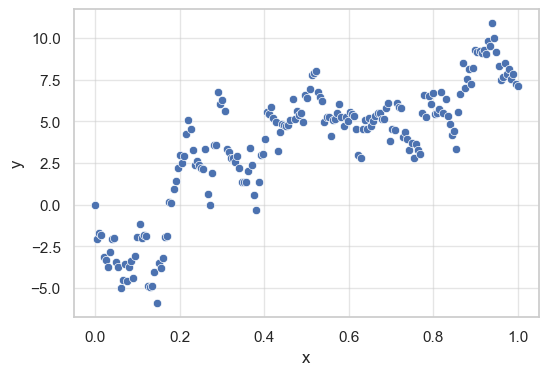

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(sample_data, x="x", y="y",ax=ax);

# Introduction to `patsy`

`patsy` is a package for describing statistical models and generating design matrices.
It is particularly useful for splines.

Before getting to splines it's worth getting used to the `patsy` syntax.

### Linear regression

We'll start by just doing linear regression: `y = ax +b`.

In [6]:
# design matrix for y ~ x + 1 (intercept is automatically added)
dmatrix("x", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 2)
  Intercept  x
          1  1
          1  2
          1  3
  Terms:
    'Intercept' (column 0)
    'x' (column 1)

In [7]:
# can generate the y-value but this generally isn't necessary
y_, _ = dmatrices("y ~ x", {"x": [1, 2, 3], "y": [4, 5, 6]})
y_

DesignMatrix with shape (3, 1)
  y
  4
  5
  6
  Terms:
    'y' (column 0)

In [8]:
# we can remove the intercept by adding '-1'
dmatrix("x - 1", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 1)
  x
  1
  2
  3
  Terms:
    'x' (column 0)

Once we have the design matrix we can fit a linear model in the usual way.

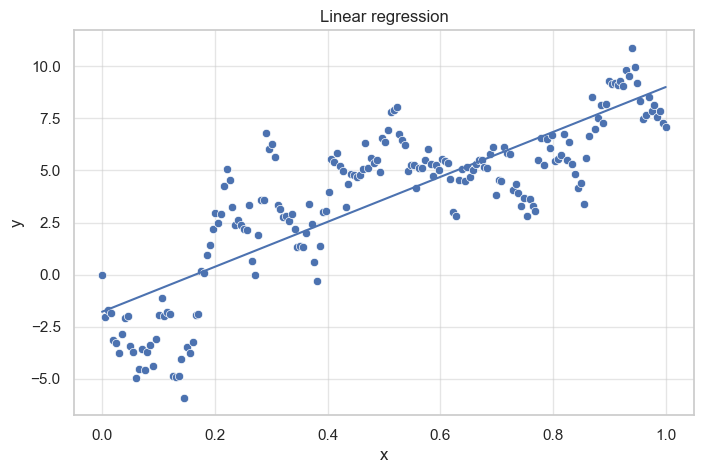

In [9]:
# in practice we input the data as a DataFrame (or Series)
X = dmatrix("x", sample_data)

# the intercept is already in the design matrix
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, sample_data.y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Linear regression");

To predict on new data we make a new design matrix based on information from the one we used for fitting.

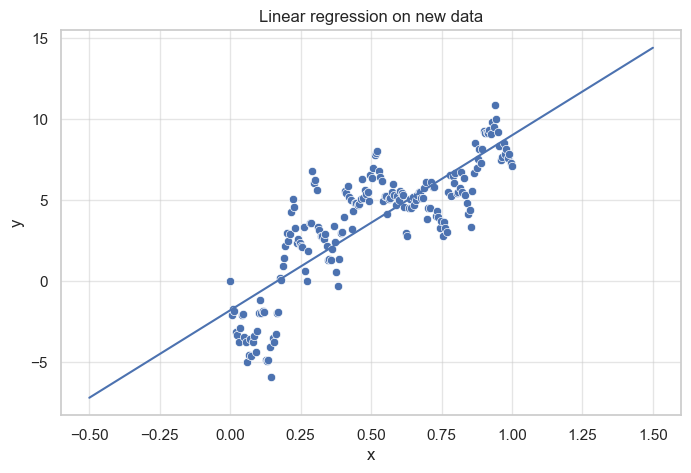

In [10]:
x_new = np.linspace(-0.5, 1.5, 100)
X_new = build_design_matrices([X.design_info], {"x": x_new})[0]

y_pred_new = lin_reg.predict(X_new)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(x_new, y_pred_new)
ax.set(title="Linear regression on new data");

### Categorical data

`patsy` handles categorical variables automatically.
By default it uses one-hot encoding.

In [11]:
dmatrix("x_cat", {"x_cat": ["cat1", "cat2", "cat3"]})

DesignMatrix with shape (3, 3)
  Intercept  x_cat[T.cat2]  x_cat[T.cat3]
          1              0              0
          1              1              0
          1              0              1
  Terms:
    'Intercept' (column 0)
    'x_cat' (columns 1:3)

Not that it automatically selects one category to remove.
If we remove the intercept it keeps the design matrix at full rank by keeping all categories:

In [12]:
dmatrix("x_cat - 1", {"x_cat": ["cat1", "cat2", "cat3"]})

DesignMatrix with shape (3, 3)
  x_cat[cat1]  x_cat[cat2]  x_cat[cat3]
            1            0            0
            0            1            0
            0            0            1
  Terms:
    'x_cat' (columns 0:3)

# 5.2 Piecewise Polynomials and Splines

## Splines

Suppose we have $K$ *knots* $\xi_1<\cdots \xi_K$.
An order-$M$ spline with knots $\xi_j$ is a piecewise polynomial of order $M$ on each interval $(-\infty, \xi_1), (\xi_1, \xi_2), \ldots (\xi_{K-1}, \xi_K), (\xi_K, \infty)$ with continuous derivatives up to order $M-2$ at each knot.

Note that order $M$ means degree $d=M-1$.
In practice we only ever use $M=2$, piecewise linear curves, or $M=4$, cubic splines.

A simple default for knot placement is to use quantiles of the data.

*Note:* It may be necessary to restrict to unique values before taking quantiles to avoid duplicate knots.

## Degrees of freedom

An order-$M$ spline consists of $K+1$ order $M$ polynomials, each contributing $M$ degrees of freedom.
The boundary conditions at the $K$ knots each remove $M-2$ degrees of freedom, so in total we have

\begin{equation}\tag{full rank splines}
    \text{df} = M + K.
\end{equation}

Note that this set of splines will be of full rank; that is, it includes an intercept.
If we build a model with splines for multiple features we need to reduce the degrees of freedom by 1 to avoid introducing redundency:

\begin{equation}\tag{no intercept splines}
    \text{df} = M + K - 1.
\end{equation}

## Spline bases

There are many equivalent splines bases.
The *$B$-spline* basis is efficient even for large $K$ so is often used.

The B-spline basis involves adding boundary knots outside the domain of your data- $M$ to the left and $M$ to the right.
So, when fitting cubic splines on data defined on [0, 1] we might add (interior) knots at 0.25, 0.5, and 0.75 and 4 boundary knots each at 0 and 1.
Some implementations (`patsy`) do this automatically but some (`scipy.interpolate.BSpline`) require you to specify the boundary knots.

## Splines in `patsy`

`patsy` is a convenient package for splines.
It takes care of generating the design matrices.
There is also an implementation in `scipy.interpolate.BSpline` but I find it less intuitive.
This allows extrapolation using the outer fitted polynomials, but this is probably a bad idea.

We fit cubic splines exactly as with Linear Regression, we just change the formula that goes into the design matrix.
By default, `patsy` takes quantiles of the data for the position of the knots, but this is configurable with the `knots` argument.
Note that this is quantiles *after removing duplicate x-values*. 

In [13]:
X = dmatrix("bs(x, df=7, degree=3, include_intercept=True) - 1", sample_data)
X

DesignMatrix with shape (200, 7)
  Columns:
    ['bs(x, df=7, degree=3, include_intercept=True)[0]',
     'bs(x, df=7, degree=3, include_intercept=True)[1]',
     'bs(x, df=7, degree=3, include_intercept=True)[2]',
     'bs(x, df=7, degree=3, include_intercept=True)[3]',
     'bs(x, df=7, degree=3, include_intercept=True)[4]',
     'bs(x, df=7, degree=3, include_intercept=True)[5]',
     'bs(x, df=7, degree=3, include_intercept=True)[6]']
  Terms:
    'bs(x, df=7, degree=3, include_intercept=True)' (columns 0:7)
  (to view full data, use np.asarray(this_obj))

Note the default is `include_intercept=False`, but setting it to `True` and removing the `Intercept` column makes the number of knots agree with our formulation above: $\text{df} = K + 4$.

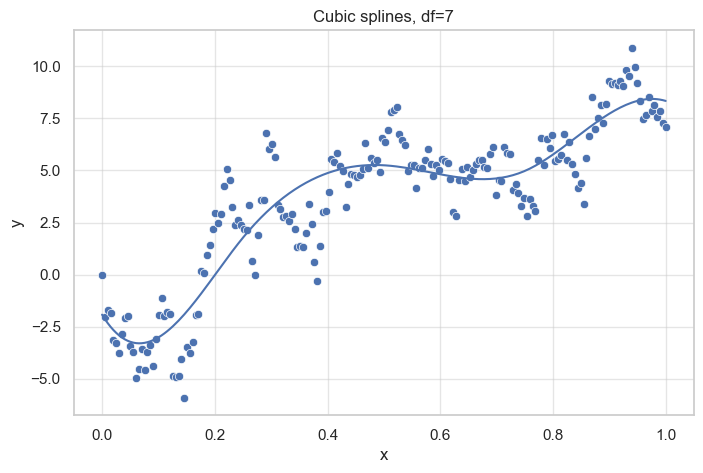

In [14]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y", ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Cubic splines, df=7");

We get the same result if we set `include_intercept=False` and keep the intercept in.
Note that we have to reduce the degrees of freedom by 1:

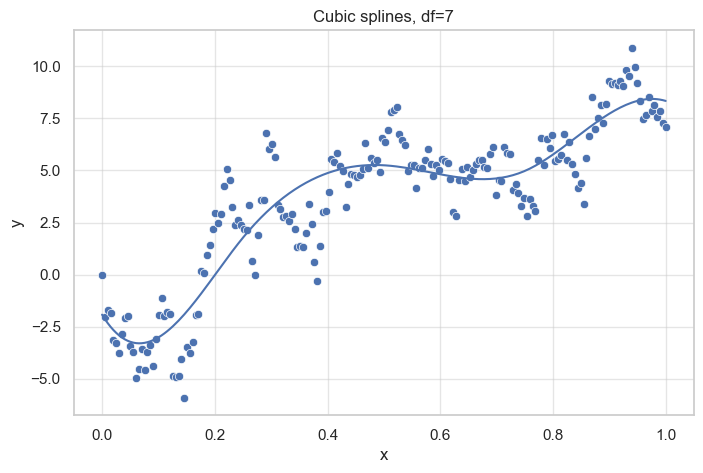

In [15]:
X = dmatrix("bs(x, df=6, degree=3, include_intercept=False)", sample_data)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y", ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Cubic splines, df=7");

`patsy` uses B-spline bases.
We can visualise the individual basis functions.

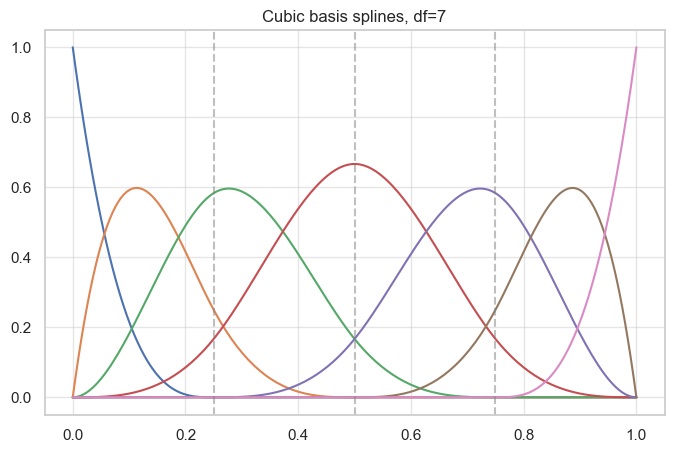

In [16]:
X = dmatrix("bs(x, df=7, degree=3, include_intercept=True) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(7)
ax.plot(x, X*b)

# plot knot locations
n_knots = 7 - 4 # df = K + 4
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Cubic basis splines, df=7");

Removing the intercept is equivalent to forcing the splines to all be zero at the leftmost point:

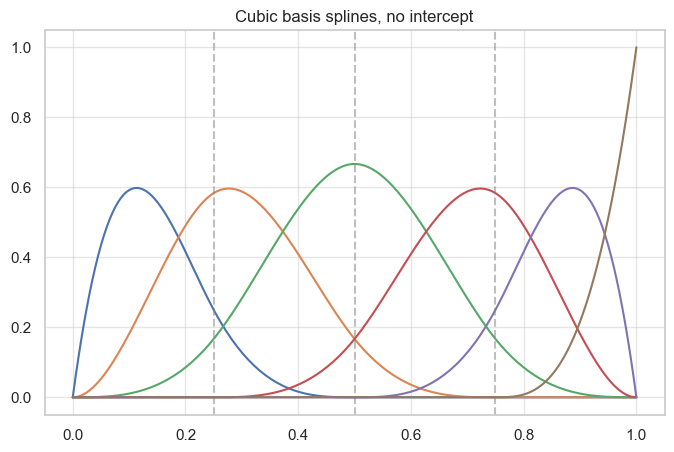

In [17]:
X = dmatrix("bs(x, df=6, degree=3, include_intercept=False) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X*b)

# plot knot locations
n_knots = 6 - 3 # df = K + 4 - 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Cubic basis splines, no intercept");

We can see how changing the degrees of freedom affects the spline curve

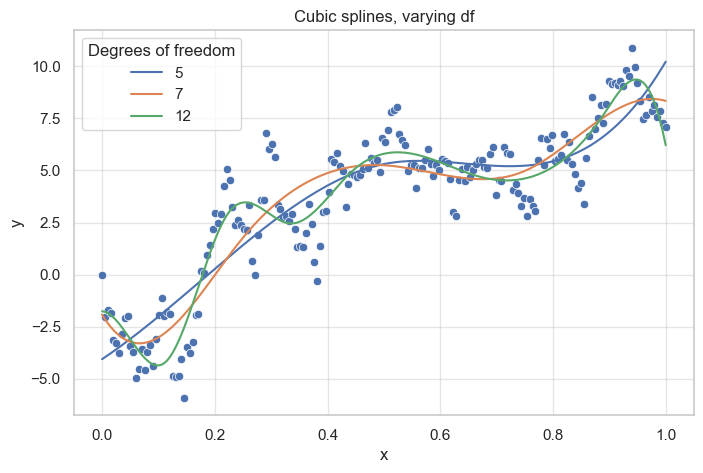

In [18]:
degrees_of_freedom = [5, 7, 12]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

for df in degrees_of_freedom:
    X = dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", sample_data)

    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    y_pred = lin_reg.predict(X)

    ax.plot(sample_data.x, y_pred, label=str(df))

ax.set(title="Cubic splines, varying df")
ax.legend(title="Degrees of freedom");

## 5.2.1 Natural cubic splines

The plot above suggests that cubic splines have high variance near the boundary.
We can reduce this by adding the additional constraint that the function is linear outside the boundary knots.
Such a spline is called a *natural cubic spline*.

These constraints remove two degrees of freedom as each end.
As a consequence we have:

\begin{equation}\tag{full rank natural cubic splines, no boundary knots}
    \text{df} = K.
\end{equation}

*Note:* There is some ambiguity around what we mean by 'outside the boundary knots'.
The construction in the chapter seems to take this to mean $\xi_1$ and $\xi_K$, but in the definition of B-splines at the end of the chapter we add additional knots $\xi_0$ and $\xi_{K+1}$ which are described as 'boundary knots'.
The question is whether we constrain the function to be linear outside the bounds of the data or if that restriction starts within the data range.

If we do add two boundary knots then we get back two degrees of freedom:

\begin{equation}\tag{full rank natural cubic splines, with boundary knots}
    \text{df} = K + 2.
\end{equation}


### In `patsy`

`patsy` has an implementation of natural cubic splines using a modification of B-splines as a basis.
By default it adds the minimum and maximum of the data as boundary knots and enforces the linearity outside those bounds.
These boundary knots can be changed using the `lower_bound` and `upper_bound` arguments.
As a consequence the degreees of freedom formula is:

\begin{equation}\tag{full rank cr in patsy}
    \text{df} = K + 2.
\end{equation}

We can compare cubic splines and natural cubic splines with the same number of degrees of freedom.
The regular cubic splines can't extrapolate, but the natural splines are able to extrapolate linearly.

In [19]:
def fit_predict_from_dmatrix(X, y, x_pred):
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    X_pred = build_design_matrices([X.design_info], {"x": x_pred})[0]
    return lin_reg.predict(X_pred)

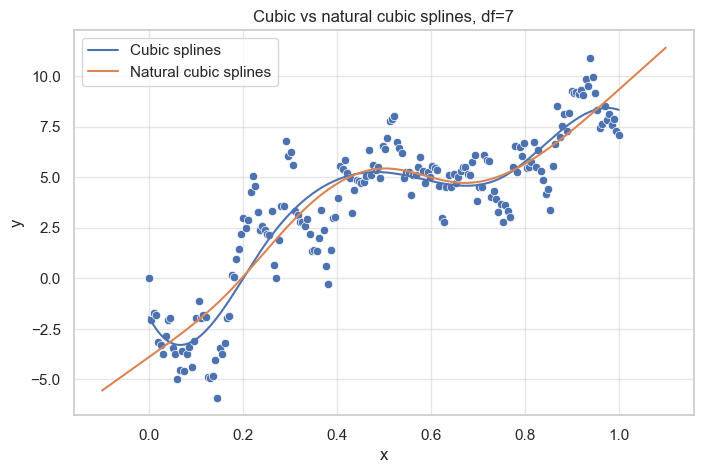

In [20]:
X = dmatrix("bs(x, df=7,  degree=3, include_intercept=True) - 1", sample_data)
X_nat = dmatrix("cr(x, df=7) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

x_pred = x # cubic splines are only defined within the range of the data
y_pred = fit_predict_from_dmatrix(X, y, x_pred)
ax.plot(x_pred, y_pred, label="Cubic splines")

# extend to show extrapolation
x_pred = np.linspace(-0.1, 1.1, 200)
y_nat_pred = fit_predict_from_dmatrix(X_nat, y, x_pred)
ax.plot(x_pred, y_nat_pred, label="Natural cubic splines")


ax.set(title="Cubic vs natural cubic splines, df=7")
ax.legend();

Note how the natural cubic splines are regularised near the boundary.

By default natural cubic splines in `patsy` are full rank - they include an intercept term.
We can remove this by adding a constraint.
The constraint itself doesn't matter - `[1, 0, .., 0]` will force the splines to all be zero at the lower bound, `'center'` is fine as a default.
Of course this will reduce the degrees of freedom by 1:

\begin{equation}\tag{no intercept cr in patsy}
    \text{df} = K + 1.
\end{equation}

Let's see how naturality has affected the basis functions - note that we get a lot more knots:

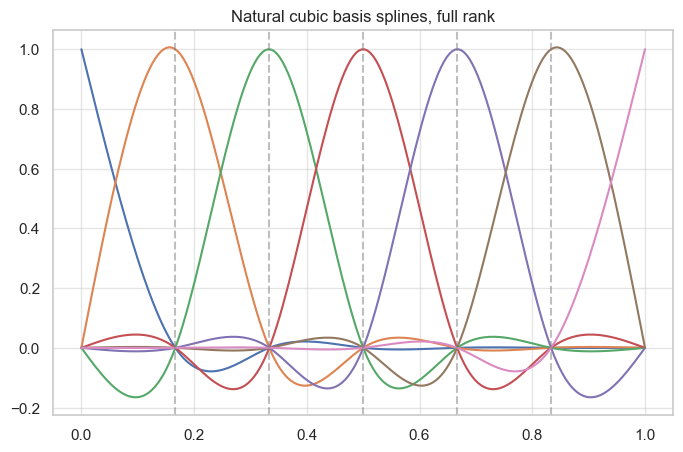

In [21]:
X_nat = dmatrix(f"cr(x, df=7) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(7)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 2
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

With centering constraints:

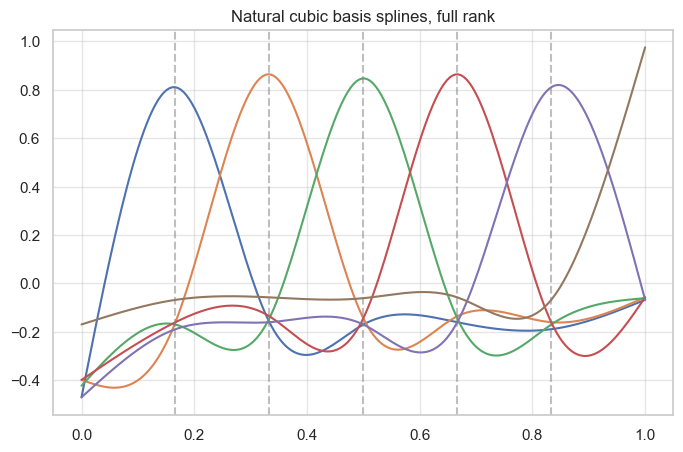

In [22]:
X_nat = dmatrix(f"cr(x, df=6, constraints='center') - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

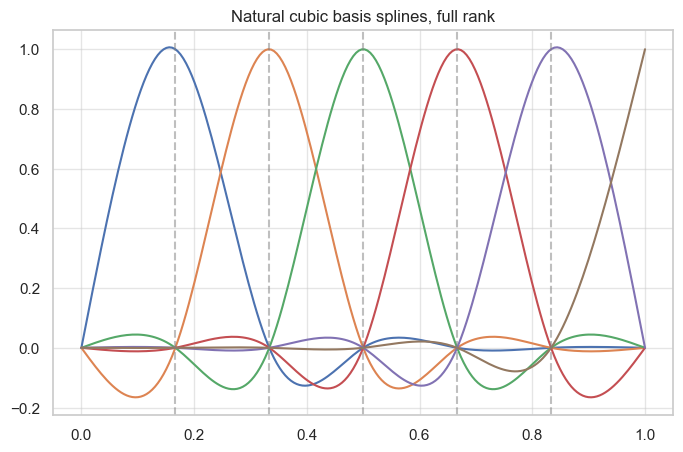

In [23]:
X_nat = dmatrix(f"cr(x, df=6, constraints=[1, 0, 0, 0, 0, 0, 0]) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

## 5.2.2 Example: South African Heart Disease

I want to recreate this example from the book.
The implementation can be found in `heart_model.py`.

In [24]:
heart_data = pd.read_csv(const.SOUTH_AFRICAN_HEART_DISEASE_DATA_PATH, index_col=0)

I'll just use the features they found rather then implementing backwards selection

/Users/c.leonard/P/elements-of-statistical-learning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


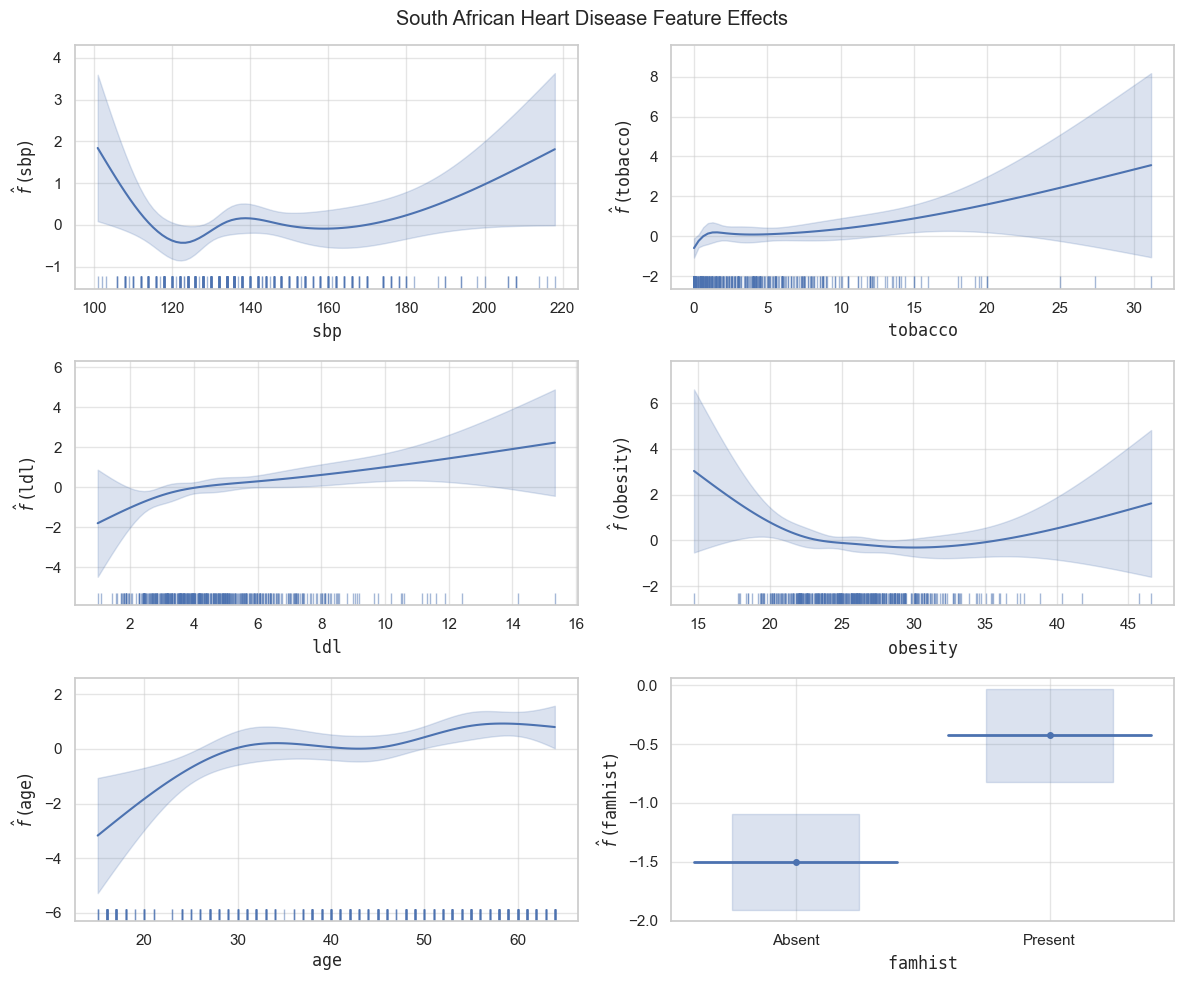

In [25]:
feature_types = {
    "sbp": "numerical",
    "tobacco": "numerical",
    "ldl": "numerical",
    "obesity": "numerical",
    "age": "numerical",
    "famhist": "categorical",
}
heart_disease_model = HeartDiseaseModel(heart_data, feature_types)
heart_disease_model.fit()
heart_disease_model.plot_all_feature_effects();

Some comments on the implementation:
- The $y$-values above are different from the book but are essentially arbitrary - differences can be absorbed by the intercept term.
- Fitting the model is exactly the same as the linear regression examples above, just using `LogisticRegression` instead.
- To faithfully reproduce what's in the book I needed to set to knots manually as the default selection in patsy removes duplicates among the x-values. This is has advantages - trying to fit the model with more degrees of freedom fails because you get duplicate knots.
- `patsy` makes it easy to define the $\hat{f}_j$, using `X.design_info.subset(formula)` to get a subdesign matrix for a single feature and `design_info.slice(feature_formula)` to get the slice object for indices.
- The fact that `patsy` automatically adjusts the encoding categorical variables to enforce full rank if you remove the intercept from the formula is quite annoying. It means that I couldn't choose to have the intercept term added in the regression itself.

# 5.4 Smoothing Splines

Consider the following problem: among all functions $f(x)$ with two continuous derivatives, find one that minimises the penalised residual sum of squares:

\begin{equation*}
    \text{RSS}(f, \lambda) = \sum_{i=1}^N \left(y_i - f(x_i)\right)^2 + \lambda \int f^{\prime\prime}(x)^2 \,\mathrm{d}x.
\end{equation*}

This has a unique minimiser: a natural cubic spline with knots at the unique values of the $x_i$.

One we know the form of the solution, solve this is just an application of Ridge regression.
The solution is $f(x) = \sum_{j=1}^N \hat{\theta}_j N_j(x)$, where the $N_j(x)$ form a spline basis and

\begin{equation*}
    \hat{\theta} = \left( \mathbf{N}^T \mathbf{N} + \lambda \mathbf{\Omega}\right)^{-1} \mathbf{N}^T \mathbf{y},
\end{equation*}

for $\lbrace \mathbf{N}\rbrace_{ij} = N_j(x_i)$ and $\lbrace \mathbf{\Omega}\rbrace_{ij} = \int N_i^{\prime\prime}(t)N_j^{\prime\prime}(t) \,\mathrm{d}t$.

### Duplicate $x$-values

The solution above elides the possibility that two $x$ values are the same, but in practice this isn't a problem.
Since

\begin{equation*}
    \left( y_1 - f(x)\right)^2 + \left( y_2 - f(x)\right)^2 = (y_1 - \bar{y})^2 + (y_2 - \bar{y})^2 + 2\left(\bar{y} - f(x)\right)^2,
\end{equation*}

where $\bar{y} = \left(y_1 + y_2\right)/2$, we can replace multiple observations with the same $x$-value with a single observation with the mean $y$-value, weighted by the original number of observations.

This is useful as implementations always seem to assume that the $x$-values are unique.

### CSAPS

In python, smoothing splines are implemented in `csaps`, or Cubic Spline APproximation (there is another implementation in SciPy.
Their formulation is slightly different, though equivalent.
They seek to minimise:

\begin{equation*}
    p \sum_{i=1}^N w_i \left(y_i - f(x_i)\right)^2 + (1-p) \int f^{\prime\prime}(x)^2 \,\mathrm{d}x,
\end{equation*}

where the $w_i$ are weights and $p$ determines smoothing.
You can convert between the formulations via

\begin{equation*}
    \lambda = \frac{1-p}{p}, \qquad\qquad p = \frac{1}{1 + \lambda}.
\end{equation*}

We can use the weights to deal with duplicate $x$-values in the data.

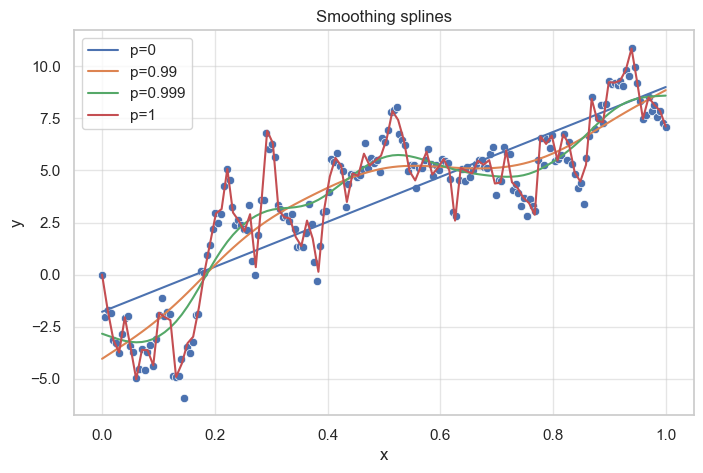

In [32]:
p_vals = [0, 0.99, 0.999, 1]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y",ax=ax)

x_vals = np.linspace(0, 1, 100)
for p in p_vals:
    y_vals = csaps(sample_data.x, sample_data.y, x_vals, smooth=p)
    ax.plot(x_vals, y_vals, label=f"p={p}")

ax.set(title="Smoothing splines")
ax.legend();

It's simple to implement the weighting for duplicate $x$-values.
The implementation is a big more complicated than it needs to be because later we will want it to work for 2-dimensional y.

In [ ]:
# def deduplicate_x_values(x, y):
#     """Deduplicate x values and average corresponding y values with weights w."""
#     df = pd.DataFrame({"x": x, "y": y, "w": 1})
#     df = df.groupby("x", set_index=False).agg({"y": "mean", "w": "sum"})
#     return df.index.values, df.y.values, df.w.values

def deduplicate_x_values(x, y):
    """Deduplicate x values and average corresponding y values with weights w."""
    df = pd.DataFrame(
        index=x,
        data=np.array(y).T
    )
    means = df.groupby(level=0).mean()
    sizes = df.groupby(level=0).size()
    
    # if y is 1d we want to return a 1d output
    if means.shape[1] == 1:
        means = means.squeeze()
    
    return means.index.values, means.values, sizes.values


def smoothing_spline(xdata, ydata, xidata, smooth, **kwargs):
    x, y, w = deduplicate_x_values(xdata, ydata)
    return csaps(x, y, xidata, smooth=smooth, weights=w,**kwargs)

Let's check that this works

In [136]:
# Load the bone data - this has duplicate x-values
bone_data = pd.read_csv('../data/bone.data', sep='\s+')
bone_data.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


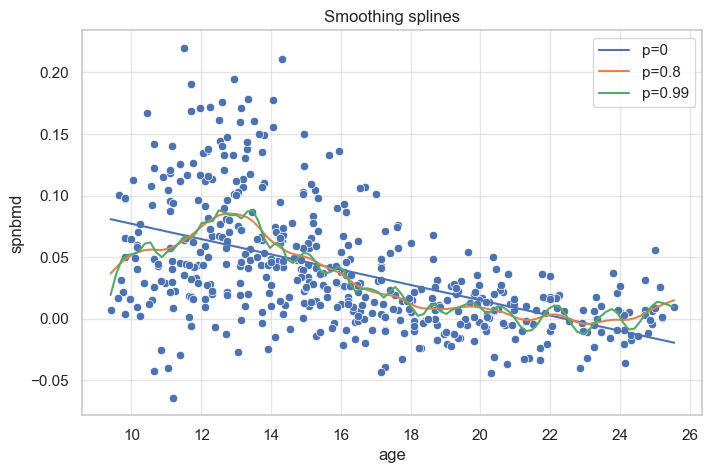

In [137]:
p_vals = [0, 0.8, 0.99]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(bone_data, x="age", y="spnbmd",ax=ax)

x_vals = np.linspace(bone_data.age.min(), bone_data.age.max(), 100)
for p in p_vals:
    y_vals = smoothing_spline(bone_data.age, bone_data.spnbmd, x_vals, smooth=p)
    ax.plot(x_vals, y_vals, label=f"p={p}")

ax.set(title="Smoothing splines")
ax.legend();

## 5.4.1 Degrees of Freedom and Smoother Matrices

### Smoother matrix

We can evaluate the fitted smoothing spline model $\hat{f}(x_i)$ at the training points with the following formula

\begin{equation*}
    \hat{f}(\mathbf{x}) = \mathbf{N}\left( \mathbf{N}^T \mathbf{N} + \lambda \mathbf{\Omega}\right)^{-1} \mathbf{N}^T \mathbf{y} = \mathbf{S}_{\lambda} \mathbf{f},
\end{equation*}

where we call $\mathbf{S}_{\lambda}$ the *smoother matrix*.
Note that this is only dependent on $\mathbf{x}$.

### Degrees of freedom

We can use this to define degrees of freedom for a smoothing spline, with analogy to linear regression:

\begin{equation*}
    \text{df}_{\lambda} = \text{trace}(\mathbf{S}_{\lambda}).
\end{equation*}

### Eigenvalues

Since eigenvalues are invariant under similarity, this is just the sum of the eigenvalues of $\mathbf{S}_{\lambda}$.
We can work these out to be

\begin{equation*}
    \rho_k(\lambda) = \frac{1}{1+\lambda d_k}
\end{equation*}

for some $d_k$, independent of $\lambda$.
So increasing the smoothing parameter has the effect of shrinking the eignvectors $\mathbf{u}_k$ of $\mathbf{S}_{\lambda}$ with those eigenvectors with higher eigenvalues being shrunk more.

The eigenvectors $\mathbf{u}_k$ are splines themselves.
The first two eigenvectors of span the space of linear functions.
Their eigenvalues are always 1.
As the eigenvalues of $\mathbf{S}_{\lambda}$ decrease, the eigenvectors increase in complexity, showing the zero-crossing behaviour of polynomials.

Again, remember that this is so far all independent of the actual values of $y$.

Applying $\mathbf{S}_{\lambda}$ to $\mathbf{y}$ we can decompose

\begin{equation*}
    \hat{f}(\mathbf{x}) = \mathbf{S}_{\lambda} \mathbf{y} = \sum_{k=1}^N \rho_k(\lambda)\langle \mathbf{u}_k, \mathbf{y}\rangle \mathbf{u}_k
\end{equation*}

so the smoothing splines operate by decomposing $\mathbf{y}$ according to the basis of eigenvectors and shrinking the contributions using $\rho_k(\lambda)$.

### CSAPS

Thanks to [Feng Liang's notes](https://liangfgithub.github.io/Python_W5_SmoothingSpline.html) which helped with a lot with the implementation.

`csaps` doesn't expose the smoother matrix, but we can use a trick to find it.
By finding the smoothing splines, evaluated at the training $x$-values, for unit $y$-vectors we can pull out the columns of $\mathbf{S}_{\lambda}$.
Since the matrix should be symmetric, we average it with its transpose to resolve rounding errors.

Degrees of freedom are easy to calculate from the smoothing parameter, so we calculate the smoother matrix for a specified `df` by varying the smoothing parameter until we find the one that results in that `df`.

In [255]:
def calculate_smoother_matrix(x, df):
    """
    Smoother matrix for smoothing splines.
    
    Internally this finds the smooth parameter that gives approximately the right degrees of freedom.
    """
    def _calculate_smooth_matrix(smooth):
        n = len(x)
        Y = np.identity(n)
        A = smoothing_spline(x, Y, x, smooth=smooth, axis=0)
        return (A + A.T)/2
    
    def _mean_squared_error_from_df(smooth):
        smoother_matrix = _calculate_smooth_matrix(smooth)
        return (np.trace(smoother_matrix) - df)**2
        
    smooth = minimize_scalar(_mean_squared_error_from_df, bounds=(0, 1), options={'xatol': 1e-10}).x
    return _calculate_smooth_matrix(smooth)

Applying the smoother matrix to the observations $\mathbf{y}$ gives the predicted values $\hat{f}(\mathbf{x})$.

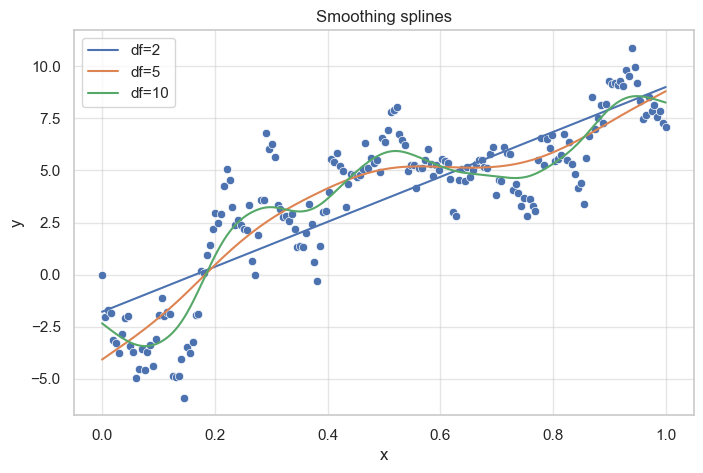

In [256]:
dfs = [2,5, 10]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y",ax=ax)

x_vals = np.linspace(0, 1, 100)
for df in dfs:
    smoother_matrix = calculate_smoother_matrix(sample_data.x, df=df)
    y_vals = smoother_matrix @ sample_data.y
    ax.plot(sample_data.x, y_vals, label=f"df={df}")

ax.set(title="Smoothing splines")
ax.legend();

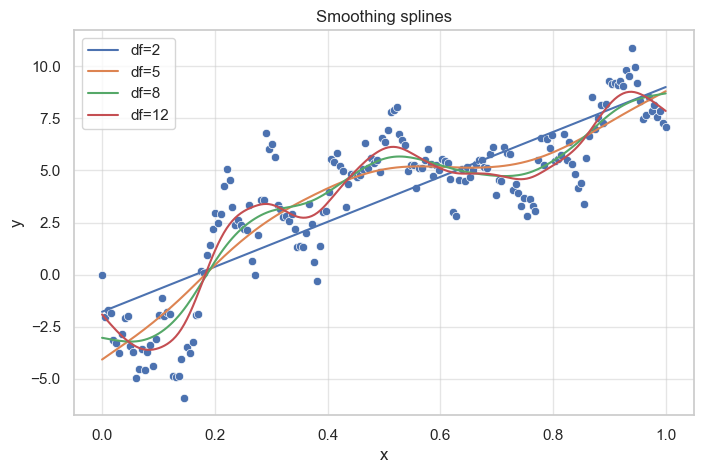

In [ ]:
dfs = [2, 5, 8, 12]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y",ax=ax)

x_vals = np.linspace(0, 1, 100)
for df in dfs:
    smoother_matrix = calculate_smoother_matrix(sample_data.x, df=df)
    y_vals = smoother_matrix @ sample_data.y
    ax.plot(sample_data.x, y_vals, label=f"df={df}")

ax.set(title="Smoothing splines")
ax.legend();

Now let's examine the eigendecomposition.
Start by plotting the eigenvalues against the number of degrees of freedom.

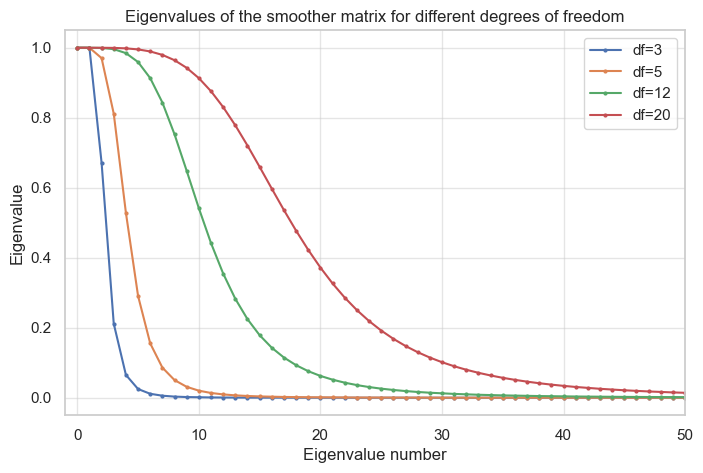

In [208]:
dfs = [3, 5, 12, 20]

fig, ax = plt.subplots(figsize=(8, 5))

for df in dfs:
    eval, _ = np.linalg.eigh(
        calculate_smoother_matrix(sample_data.x, df=df)
    )
    # plot evalues in descending order
    ax.plot(eval[::-1], marker="o", markersize=2, label=f"df={df}")

ax.set(
    xlim=[-1, 50],
    xlabel="Eigenvalue number",
    ylabel="Eigenvalue",
    title="Eigenvalues of the smoother matrix for different degrees of freedom"
)
ax.legend();

Note that the first two eigenvalues are always one.
This is because they correspond to the linear eigenvectors - even with maximal smoothing you still have the full range of linear functions.

Now let's examine the eigenvectors

In [219]:
df = 5
smoother_matrix = calculate_smoother_matrix(sample_data.x, df=df)
eval, evect = np.linalg.eigh(smoother_matrix)

# sort evalues in descending order
rev_ord = np.arange(len(eval)-1, -1, -1)
eval, evect = eval[rev_ord], evect[:, rev_ord]

Plot the first few eigenvectors, both unscaled and scaled by the eigenvalue.

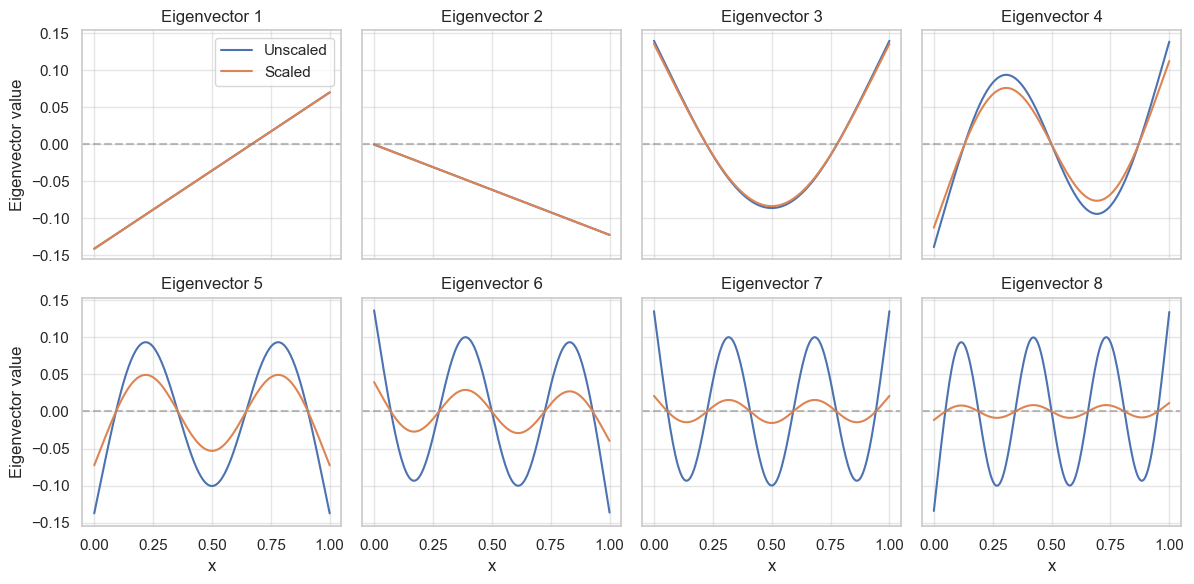

In [ ]:
display_count = 8

ncols = min(display_count, 4)
nrows = (display_count + ncols - 1) // ncols

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(3 * ncols, 3 * nrows))

# Flatten axs if it's a 2D array
axs = np.array(axs).reshape(-1)

for i, ax in enumerate(axs):
    ax.plot(sample_data.x, evect[:, i], label="Unscaled")
    ax.plot(sample_data.x, eval[i] * evect[:, i], label="Scaled")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
    ax.set(
        title=f"Eigenvector {i+1}",
    )
    if i >= display_count - ncols:
        ax.set(xlabel="x")
    if i == 0:
        ax.legend()

# Hide unused subplots
for j in range(display_count, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()

The smoother matrix acts by shrinking.
I see no reason why we can't also do projection, by analogy with L1 regularisation.
All we need to do is set the first `df` of the eigenvalues to 1 and the rest to zero.
This is implemented below.

In [284]:
def l1_smoothing_spline(x, y, df):
    # get the eigenvectors of the smoother matrix
    smoother_matrix = calculate_smoother_matrix(x, df=len(x))
    _, evect = np.linalg.eigh(smoother_matrix)

    # sort eigenvalues in descending order
    rev_ord = np.arange(len(evect)-1, -1, -1)
    evect = evect[:, rev_ord]
    
    # project onto the first df eigenvectors
    projection_matrix = evect[:, :df] @ evect[:, :df].T
    return projection_matrix @ y

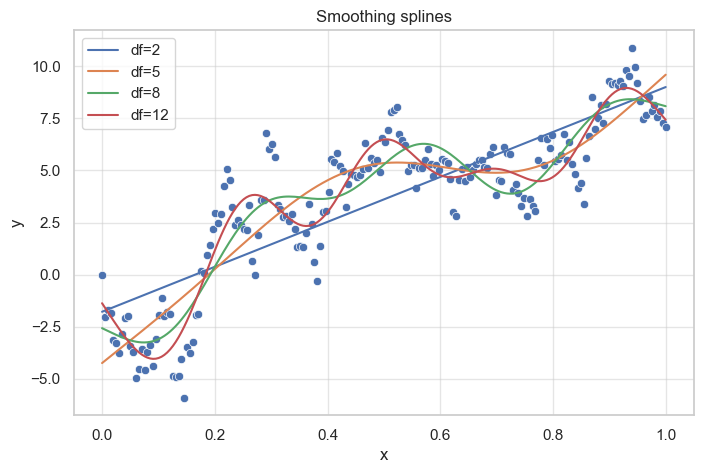

In [286]:
dfs = [2, 5, 8, 12]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y",ax=ax)

for df in dfs:
    projection_eval = np.concatenate([np.ones(df), np.zeros(len(sample_data.x) - df)])
    y_vals = l1_smoothing_spline(sample_data.x, sample_data.y, df=df)
    ax.plot(sample_data.x, y_vals, label=f"df={df}")

ax.set(title="Smoothing splines")
ax.legend();

These aren't mentioned in the book but seem perfectly reasonable to me.
I don't know if there are advantages or disadvantages to them.